**Description:** This notebook demonstrates the preprocessing, dataset creation, and filtering steps our our pipeline on a simple example consisting of 2 objects: a source object derived from an RGBD image, and a second fully known object we will refer to as the template. The goal is to transfer information from the template object to the partially occluded source object in order to obtain a probabilistic model of its full 3D geometry. The notebook creates visualizations that were used to create Fig.1 and Fig.2 of the accompanying paper.

Note: This notebook produces a number of 3D pointcloud visualizations using the Open3D visualizer. In the visualization window, you can move the pointcloud using **left-click**, zoom in with the **mouse wheel**, and increase/decrease point size using **+/-** keys.

In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import open3d as o3d
from matplotlib import pyplot as plt
import torch
import json
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
import copy
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
VIMEX_BASE_DIR = '..'
import sys
sys.path.append(VIMEX_BASE_DIR)
import vimex
from vimex import rgbd, dpc, se, vis

# Preprocessing

Given an RGBD image of an object $\mathcal{O}$ (i.e., Oreo cereal box), a set of pixel-wise descriptors $\{\mathbf{z}_i \in \mathbb{R}^{1024}\}$ is extracted using the spatial value tokens of the final attention layer from the DINOv2 ViT backbone. These descriptors are backprojected into 3D using depth values, and per point surface normals (i.e., unit vectors perpendicular to the object surface) are computed, resulting in a descriptor pointcloud $\mathcal{S}_{\mathcal{O}} = \{(\mathbf{p}_i, \hat{\mathbf{n}}_i, \mathbf{z}_i)\}$ where every 3D point $\mathbf{p}_i \in \mathbb{R}^3$ has an associated descriptor $\mathbf{z}_i$ and surface normal $\hat{\mathbf{n}}_i \in \mathbb{R}^3$. We also assume a template mesh $\mathcal{T}$ from the same semantic category as $\mathcal{O}$ (i.e., Bob Ross cereal box) is available with complete 3D information, processed in the same way to create a descriptor pointcloud $\mathcal{S}_{\mathcal{T}} = \{(\mathbf{p}_j, \hat{\mathbf{n}}_j, \mathbf{z}_j)\}$.

## Create DPC for First Scan

All preprocessing steps applied to the first object (Oreo cereal box). \
Note that at test time, we assume that we only have a single RGBD image for this object.\
Therefore the preprocessing steps in this part (which produce complete 3D geometry) are only performed to compute ground truth evaluation metrics for comparison.

### Read RGBD Images

Read pre-saved RGBD images.

In [3]:
DEPTH_PATHS = sorted(glob('oreo_scan/DepthCapture*'))
RGB_PATHS = sorted(glob('oreo_scan/ScreenCapture*'))
CAMERA_PATHS = sorted(glob('oreo_scan/ScreenCamera*'))

assert len(DEPTH_PATHS) == len(RGB_PATHS) == len(CAMERA_PATHS)

In [4]:
camera_intrinsics = json.load(open(CAMERA_PATHS[0]))

In [5]:
camera_intrinsics

{'class_name': 'PinholeCameraParameters',
 'extrinsic': [-0.06217257963331753,
  -0.4786700370197048,
  0.875790823199977,
  0.0,
  -0.008470278310024863,
  -0.8772037444807489,
  -0.48004358661928176,
  0.0,
  0.9980294708710207,
  -0.037263740130420234,
  0.05048355122614689,
  0.0,
  -0.0,
  5.084908188957016e-17,
  0.47236171262787247,
  1.0],
 'intrinsic': {'height': 1080,
  'intrinsic_matrix': [935.3074360871938,
   0.0,
   0.0,
   0.0,
   935.3074360871938,
   0.0,
   959.5,
   539.5,
   1.0],
  'width': 1920},
 'version_major': 1,
 'version_minor': 0}

In [6]:
rgbd_list_1 = []
mask_list_1 = []
for img_id in tqdm(range(len(RGB_PATHS))):
    rgb = np.array(Image.open(RGB_PATHS[img_id])) # 0-255 uint8
    depth = np.array(Image.open(DEPTH_PATHS[img_id])) / 1000 # float, in meters
    mask = depth != 0
    camera_parameters = json.load(open(CAMERA_PATHS[img_id]))
    camera_pose = np.linalg.inv(np.array(camera_parameters['extrinsic']).reshape(4,4).transpose())
    camera_K = np.array(camera_parameters['intrinsic']['intrinsic_matrix']).reshape(3,3).transpose()
    rgbd_list_1.append(vimex.rgbd.RGBDImage(rgb, depth, camera_K, camera_pose))
    mask_list_1.append(mask)

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 39.30it/s]


Show one of the RGBD images.

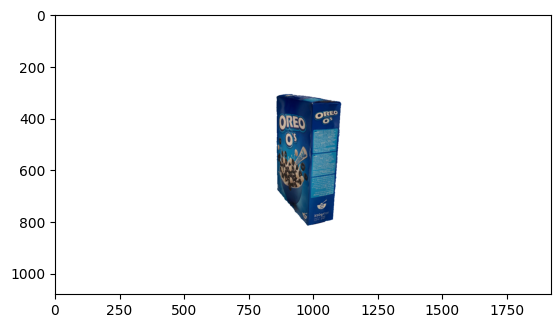

In [7]:
plt.imshow(rgbd_list_1[1].rgb)

### Extract Descriptors

We utilise a pre-trained DINOv2 (https://arxiv.org/abs/2304.07193) model to extract pixel-wise descriptor features from the RGBD images.

In [8]:
from vimex.backbone import ViTBackbone
model_type = 'dinov2_vitl14'
stride = 7
# stride = 14
device = torch.device("cuda")
descriptor_model = ViTBackbone(model_type, stride, device=device)

Using cache found in /home/onur/.cache/torch/hub/facebookresearch_dinov2_main
/home/onur/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/onur/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/onur/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [9]:
for rgbd_img, mask in tqdm(zip(rgbd_list_1, mask_list_1)):
    rgbd.extract_descriptor_data_(rgbd_img, descriptor_model, mask)

0it [00:00, ?it/s]/home/onur/miniconda3/envs/vimex/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
9it [00:02,  3.59it/s]


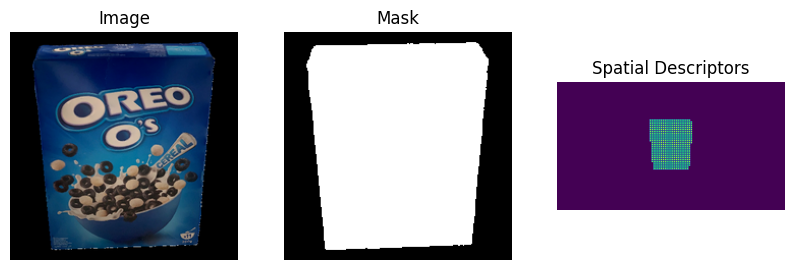

In [10]:
vis.show_descriptor_data(rgbd_list_1[0].descriptor_data, rgbd_list_1[0].depth.shape, dilation_kernel_size=11)

### Backproject Spatial Descriptors

These descriptors are then projected back into 3D space using depth information

In [11]:
dpc_list_1 = [rgbd.backproject_rgbd_to_dpc(rgbd_img) for rgbd_img in rgbd_list_1]
pcd_list_1 = [dpc.pcd for dpc in dpc_list_1]

In [12]:
obj_dpc_1 = vimex.dpc.join_descriptor_pointclouds(dpc_list_1)

Visualize the backprojection result.

In [13]:
# o3d.visualization.draw_geometries(pcd_list)
o3d.visualization.draw_geometries([obj_dpc_1.pcd])
o3d.io.write_point_cloud('obj_dpc_1.ply', obj_dpc_1.pcd)

True

In [14]:
obj_dpc_1.pcd

PointCloud with 3144 points.

## Create DPC for the Second Scan

The same preprocessing steps as before, repeated for the second object (i.e., Bob Ross cereal box). \
This part produces the descriptor pointcloud $\mathcal{S}_{\mathcal{T}} = \{(\mathbf{p}_j, \hat{\mathbf{n}}_j, \mathbf{z}_j)\}$.

### Read RGBD Images

In [15]:
DEPTH_PATHS = sorted(glob('bob_scan/DepthCapture*'))
RGB_PATHS = sorted(glob('bob_scan/ScreenCapture*'))
CAMERA_PATHS = sorted(glob('bob_scan/ScreenCamera*'))

assert len(DEPTH_PATHS) == len(RGB_PATHS) == len(CAMERA_PATHS)

In [16]:
camera_intrinsics = json.load(open(CAMERA_PATHS[0]))

In [17]:
camera_intrinsics

{'class_name': 'PinholeCameraParameters',
 'extrinsic': [0.028230276380281,
  -0.5910642140571445,
  0.8061303532038123,
  0.0,
  0.0013445796610419157,
  -0.8064285845234577,
  -0.5913299672509653,
  0.0,
  0.999600542017174,
  0.01777731488450365,
  -0.021970968901465045,
  0.0,
  -0.0038488868765041116,
  0.0357701144117307,
  0.4108094786883198,
  1.0],
 'intrinsic': {'height': 1080,
  'intrinsic_matrix': [935.3074360871938,
   0.0,
   0.0,
   0.0,
   935.3074360871938,
   0.0,
   959.5,
   539.5,
   1.0],
  'width': 1920},
 'version_major': 1,
 'version_minor': 0}

In [18]:
rgbd_list_2 = []
mask_list_2 = []
for img_id in tqdm(range(len(RGB_PATHS))):
    rgb = np.array(Image.open(RGB_PATHS[img_id])) # 0-255 uint8
    depth = np.array(Image.open(DEPTH_PATHS[img_id])) / 1000 # float, in meters
    mask = depth != 0
    camera_parameters = json.load(open(CAMERA_PATHS[img_id]))
    camera_pose = np.linalg.inv(np.array(camera_parameters['extrinsic']).reshape(4,4).transpose())
    camera_K = np.array(camera_parameters['intrinsic']['intrinsic_matrix']).reshape(3,3).transpose()
    rgbd_list_2.append(vimex.rgbd.RGBDImage(rgb, depth, camera_K, camera_pose))
    mask_list_2.append(mask)

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 39.66it/s]


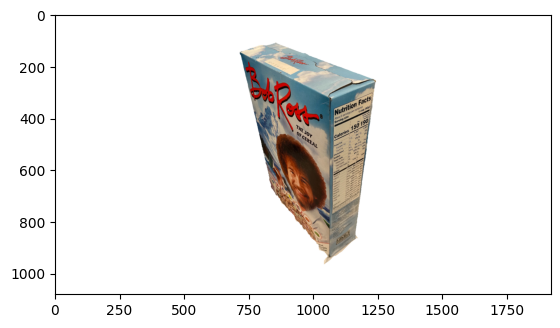

In [19]:
plt.imshow(rgbd_list_2[1].rgb)

### Extract Descriptors

In [20]:
for rgbd_img, mask in tqdm(zip(rgbd_list_2, mask_list_2)):
    rgbd.extract_descriptor_data_(rgbd_img, descriptor_model, mask)

9it [00:01,  4.59it/s]


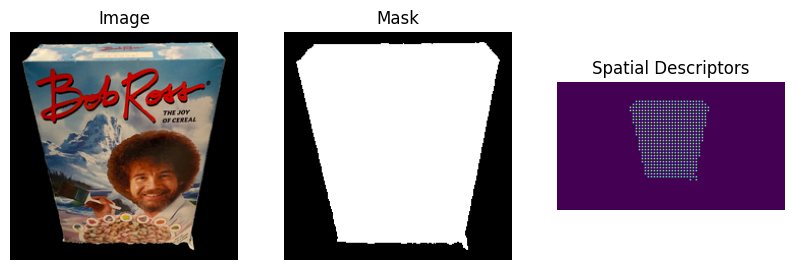

In [21]:
vis.show_descriptor_data(rgbd_list_2[0].descriptor_data, rgbd_list_2[0].depth.shape, dilation_kernel_size=11)

### Backproject Spatial Descriptors

In [22]:
dpc_list_2 = [rgbd.backproject_rgbd_to_dpc(rgbd_img) for rgbd_img in rgbd_list_2]
pcd_list_2 = [dpc.pcd for dpc in dpc_list_2]

In [23]:
obj_dpc_2 = vimex.dpc.join_descriptor_pointclouds(dpc_list_2)

In [24]:
# o3d.visualization.draw_geometries(pcd_list)
o3d.visualization.draw_geometries([obj_dpc_2.pcd])
o3d.io.write_point_cloud('obj_dpc_2.ply', obj_dpc_2.pcd)

True

In [25]:
obj_dpc_2.pcd

PointCloud with 3002 points.

## Create the source image and dpc

The same preprocessing steps applied to a single RGBD image of the first object (i.e., Oreo ceral box). \
This part produces the descriptor pointcloud $\mathcal{S}_{\mathcal{O}} = \{(\mathbf{p}_j, \hat{\mathbf{n}}_j, \mathbf{z}_j)\}$.

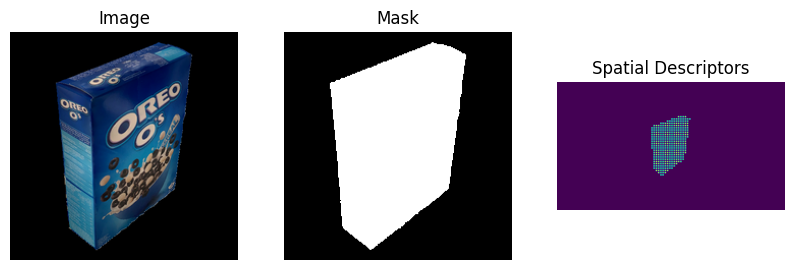

In [26]:
source_img = rgbd_list_1[7]
vis.show_descriptor_data(source_img.descriptor_data, source_img.depth.shape, dilation_kernel_size=11)

In [27]:
source_dpc = rgbd.backproject_rgbd_to_dpc(source_img)

In [28]:
o3d.visualization.draw_geometries([source_dpc.pcd])

## Surface Normal Estimation

Estimate surface normals at full resolution, and then downsample them to the DPC resolution.

In [29]:
template_mesh = o3d.io.read_triangle_mesh('/home/onur/Research/VIMEX/app/dl_reconstruction/data/bob_ross.obj', True)
template_mesh.compute_vertex_normals()
template_pcd_full = o3d.geometry.PointCloud(template_mesh.vertices)
template_pcd_full.normals = template_mesh.vertex_normals

Visualize full resolution surface normals for the template.

In [30]:
o3d.visualization.draw_geometries([template_pcd_full], point_show_normal=True)

In [31]:
source_pcd_full = rgbd.backproject_rgbd_to_pcd(source_img, source_img.depth!=0)
source_pcd_full.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
source_pcd_full.normalize_normals()
source_pcd_full.orient_normals_consistent_tangent_plane(10)

Visualize full resolution surface normals for the object RGBD image.

In [32]:
o3d.visualization.draw_geometries([source_pcd_full], point_show_normal=True)

In [33]:
source_pcd_full_tree = o3d.geometry.KDTreeFlann(source_pcd_full)
source_normals = []
for point in source_dpc.pcd.points:
    _, nn_id, _ = source_pcd_full_tree.search_knn_vector_3d(point, 1)
    source_normals.append(np.array(source_pcd_full.normals)[nn_id[0]])

source_dpc.pcd.normals = o3d.utility.Vector3dVector(np.array(source_normals))
source_dpc.pcd.normalize_normals()
source_dpc.pcd.orient_normals_consistent_tangent_plane(10)

Visualize downsamples surface normals for the object RGBD image.

In [34]:
o3d.visualization.draw_geometries([source_dpc.pcd], point_show_normal=True)

In [35]:
template_pcd_full_tree = o3d.geometry.KDTreeFlann(template_pcd_full)
template_normals = []
for point in obj_dpc_2.pcd.points:
    _, nn_id, _ = template_pcd_full_tree.search_knn_vector_3d(point, 1)
    template_normals.append(np.array(template_pcd_full.normals)[nn_id[0]])

obj_dpc_2.pcd.normals = o3d.utility.Vector3dVector(np.array(template_normals))
obj_dpc_2.pcd.normalize_normals()
obj_dpc_2.pcd.orient_normals_consistent_tangent_plane(10)

Visualize downsampled surface normals for the template

In [36]:
o3d.visualization.draw_geometries([obj_dpc_2.pcd], point_show_normal=True)

# Visualizations for Descriptors

## Interactive Feature Similarity Checking

This part provides an interactive way of checking the similarity measure between selected points of the first object and all the points of the second object. In order to select a point, use **shift + left-click**. \
Closing this first window, will open a new one showcasing the two objects, the selected point, as well as a point cloud to be read as a similarity heatmap. \
The similarity is computed using the inner product $\mathbf{z}_i^T \mathbf{z}_j$, as described in the accompanying paper.

In [37]:
translation = np.array([0, 0, obj_dpc_1.pcd.get_axis_aligned_bounding_box().get_extent()[1]*1.5])
dpc.visualize_dpc_similarities(obj_dpc_1, obj_dpc_2, translation=translation, point_size=0.01)

## BBP Matching

We can also visualise pairs of points on the two objects that match the most based on their similarity scores.

In [38]:
similarity_matrix = obj_dpc_1.descriptors @ obj_dpc_2.descriptors.T

In [39]:
bb_pair_ids = dpc.bbp_matching(similarity_matrix)

In [40]:
num_pairs_to_show = 20
dpc.visualize_bb_pairs(obj_dpc_1.pcd, obj_dpc_2.pcd, bb_pair_ids, point_size=0.01)

# Geometric Primitive Transfer to Create the Dataset

We create a 3D dataset of points $\mathcal{D}$ covering the occluded regions of the source image above, by retrieving geometric primitives (i.e., N points on the line along each surface normal) from the 3D complete template mesh from the same category (i.e., cereal boxes).

## Matching Between Source DPC and Template DPC

Matching and nearest neighbor computation based on the descriptor inner product, same as the preprocessing step above.

In [41]:
translation = np.array([0, 0, obj_dpc_1.pcd.get_axis_aligned_bounding_box().get_extent()[1]*1.5])
dpc.visualize_dpc_similarities(source_dpc, obj_dpc_2, translation=translation, point_size=0.01)

In [42]:
similarity_matrix = source_dpc.descriptors @ obj_dpc_2.descriptors.T

In [43]:
nn_from_scn_in_temp = similarity_matrix.argmax(axis=-1)
nn_from_scn_in_temp.shape

torch.Size([344])

In [44]:
bb_pair_ids.shape

(313, 2)

In [45]:
bb_pair_ids = dpc.bbp_matching(similarity_matrix)

## Retrieving Antipodal Distaces

A utility function used as a substep to compute N points on the line along each surface normal.

In [46]:
def find_antipodal_point(point_coord, point_normal, pcd, voxel_size=0.01):
    point_vec = np.asarray(pcd.points) - point_coord
    perpendicular_dist = np.linalg.norm(np.cross(point_vec, point_normal), axis=-1)
    line_dist = np.linalg.norm(point_vec, axis=-1)

    intersection_idx = (perpendicular_dist < voxel_size).nonzero()[0]
    intersection_line_dist = line_dist[intersection_idx]
    antipodal_id = intersection_idx[intersection_line_dist.argmax()]
    antipodal_distance = intersection_line_dist.max()
    
    return antipodal_distance, antipodal_id

## Creating the Dataset (without Filtering)

Get N points on the line along each surface normal over the template mesh, and move these points to the coordinate frame of the source image according to the nearest neighbors computed above.

In [47]:
antipodal_distances_unfiltered = np.zeros(source_dpc.descriptors.shape[0])
for point_id in range(source_dpc.descriptors.shape[0]):
    nn_id = nn_from_scn_in_temp[point_id]
    point_coord = obj_dpc_2.pcd.points[nn_id]
    point_normal = obj_dpc_2.pcd.normals[nn_id]
    antipodal_distance, antipodal_id = find_antipodal_point(point_coord, point_normal, obj_dpc_2.pcd, voxel_size=0.05)
    antipodal_distances_unfiltered[point_id] = antipodal_distance

In [48]:
# retrieved_points = np.zeros([source_dpc.descriptors.shape[0], 3])
retrieved_points_list = []
furthermost_points_list = []
num_points_per_line = 20
for point_id in range(source_dpc.descriptors.shape[0]):
    point_coord = source_dpc.pcd.points[point_id]
    point_normal = source_dpc.pcd.normals[point_id]
    retrieved_points = point_coord[np.newaxis, :] - point_normal[np.newaxis, :] * (np.linspace(0, 1, num_points_per_line)[:, np.newaxis] * antipodal_distances_unfiltered[point_id])
    furthermost_points_list.append(retrieved_points[-1])
    retrieved_points_list = retrieved_points_list + list(retrieved_points)

In [49]:
retrieved_pcd_unfiltered = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(np.array(retrieved_points_list)))

In [50]:
o3d.visualization.draw_geometries([retrieved_pcd_unfiltered, source_dpc.pcd])

## Creating the Dataset (with Filtering)

Filter the 3D points from the backprojection of the source image based on their total curvature $\kappa(\mathbf{p})$

In [51]:
source_dpc.pcd.estimate_covariances()
curvature = dpc.calculate_surface_curvature(source_dpc.pcd, radius=0.02, max_nn=30)
curvature = curvature / curvature.max()

Visualize the values of total curvature $\kappa(\mathbf{p})$.

In [73]:
vis_pcd = copy.deepcopy(source_dpc.pcd)
vis_pcd.colors = o3d.utility.Vector3dVector(curvature[:, np.newaxis].repeat(3, axis=-1))
o3d.visualization.draw_geometries([vis_pcd])

In [53]:
curvature_threshold = np.quantile(curvature, 0.7)
curvature_outlier_mask = curvature > curvature_threshold
curvature_outlier_mask.sum()

103

In [54]:
curvature_threshold

0.04501507511513291

Visualize the source DPC after filtering based on $\kappa(\mathbf{p})$.

In [55]:
filter_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(np.array(source_dpc.pcd.points)[~curvature_outlier_mask]))
o3d.visualization.draw_geometries([filter_pcd])

The same steps as the previous part to create the dataset.

In [56]:
similarity_topK = 50
topK_closest_id = similarity_matrix.topk(similarity_topK, dim=-1)[1]
antipodal_distances = np.zeros(source_dpc.descriptors.shape[0])
for point_id in range(source_dpc.descriptors.shape[0]):
    topK_antipodal_distances = np.zeros(similarity_topK)
    for i, nn_id in enumerate(topK_closest_id[point_id]):
        point_coord = obj_dpc_2.pcd.points[nn_id]
        point_normal = obj_dpc_2.pcd.normals[nn_id]
        antipodal_distance, antipodal_id = find_antipodal_point(point_coord, point_normal, obj_dpc_2.pcd, voxel_size=0.01)
        topK_antipodal_distances[i] = antipodal_distance

    antipodal_distances[point_id] = np.median(topK_antipodal_distances)

In [57]:
# retrieved_points = np.zeros([source_dpc.descriptors.shape[0], 3])
retrieved_points_list = []
num_points_per_line = 50
for point_id in range(source_dpc.descriptors.shape[0]):
    if curvature_outlier_mask[point_id] == False:
        point_coord = source_dpc.pcd.points[point_id]
        point_normal = source_dpc.pcd.normals[point_id]
        # retrieved_point = point_coord - point_normal * antipodal_distances[point_id]
        retrieved_points = point_coord[np.newaxis, :] - point_normal[np.newaxis, :] * (np.linspace(0, 1, num_points_per_line)[:, np.newaxis] * antipodal_distances[point_id])
        # retrieved_points[point_id] = retrieved_point
        retrieved_points_list = retrieved_points_list + list(retrieved_points)

In [58]:
retrieved_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(np.array(retrieved_points_list)))
retrieved_pcd, _ = retrieved_pcd.remove_statistical_outlier(30, 0.5)
# retrieved_pcd.paint_uniform_color([0, 1, 0])

In [59]:
o3d.visualization.draw_geometries([retrieved_pcd, source_dpc.pcd])
# o3d.visualization.draw_geometries([retrieved_pcd, source_dpc.pcd, obj_dpc_2.pcd])

# Plots

This part produces the plots used in Fig.2.

In [60]:
from tueplots import bundles
from tueplots.constants.color import rgb
plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=2, usetex=False))

In [61]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [62]:
source_mesh = o3d.io.read_triangle_mesh('/home/onur/Research/VIMEX/app/dl_reconstruction/data/oreo.obj', True)
mesh = o3d.t.geometry.TriangleMesh.from_legacy(source_mesh)
scene = o3d.t.geometry.RaycastingScene()
_ = scene.add_triangles(mesh)  # we do not need the geometry ID for mesh

## SDF vs normal covariance

In [63]:
query_point = o3d.core.Tensor(np.stack(furthermost_points_list), dtype=o3d.core.Dtype.Float32)
furthermost_point_sdfs = scene.compute_signed_distance(query_point).numpy()

In [64]:
curvature.shape

(344,)

In [65]:
furthermost_point_sdfs.shape

(344,)

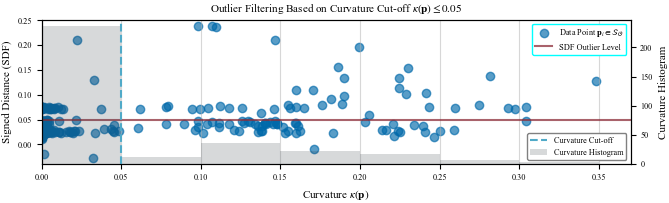

In [66]:
fig, ax = plt.subplots()
ax.set_title("Outlier Filtering Based on Curvature Cut-off $\kappa(\mathbf{p}) \leq 0.05$")
ax.set_xlabel("Curvature $\kappa(\mathbf{p})$")
ax.set_ylabel('Signed Distance (SDF)') 

ax.scatter(curvature, furthermost_point_sdfs, color=rgb.tue_blue, alpha=0.65, label='Data Point $\mathbf{p}_i \in \mathcal{S}_\mathcal{O}$')

# set the x-axis formatter to the custom function
ax.grid(axis = 'x', which = 'major', alpha = 0.5)
ax.set_xlim(0, 0.37)
# ax.set_ylim(0, 0.05)
ax.axhline(0.05, color = rgb.tue_red, alpha = 0.75, label='SDF Outlier Level')

ax2 = ax.twinx() 
 
color = 'tab:green'
ax2.set_ylabel('Curvature Histogram') 
ax2.axvline(0.05, color = rgb.tue_lightblue, alpha = 1, linestyle='--', label='Curvature Cut-off')
ax2.hist(curvature, alpha=0.2, color=rgb.tue_dark, bins=np.arange(0, 0.4, 0.05), label='Curvature Histogram')
ax2.tick_params(axis ='y') 
ax.legend(loc = 'upper right', framealpha = 1.0, facecolor = 'white', edgecolor = 'cyan')
ax2.legend(loc = 'lower right', framealpha = 1.0, facecolor = 'white', edgecolor = 'gray')
fig.savefig("normal_based_filtering.pdf")

## SDF vs Distance to Neighbors

In [67]:
retrieved_pcd_unfiltered_kdtree = o3d.geometry.KDTreeFlann(retrieved_pcd_unfiltered)

In [68]:
dist_neighbors = []
for point in retrieved_pcd_unfiltered.points:
    dist_neighbors.append(np.array(retrieved_pcd_unfiltered_kdtree.search_knn_vector_3d(point, knn=30)[-1]).mean())
dist_neighbors = np.array(dist_neighbors) * 100

In [69]:
query_point = o3d.core.Tensor(np.array(retrieved_pcd_unfiltered.points), dtype=o3d.core.Dtype.Float32)
point_sdfs = scene.compute_signed_distance(query_point).numpy()

In [70]:
dist_neighbors.shape

(6880,)

In [71]:
point_sdfs.shape

(6880,)

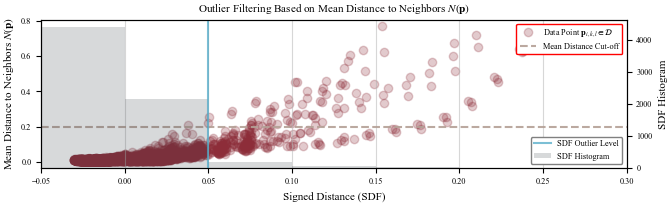

In [72]:
fig, ax = plt.subplots()
ax.set_title("Outlier Filtering Based on Mean Distance to Neighbors $N(\mathbf{p})$")
ax.set_ylabel("Mean Distance to Neighbors $N(\mathbf{p})$")
ax.set_xlabel('Signed Distance (SDF)') 

ax.scatter(point_sdfs, dist_neighbors, color=rgb.tue_red, alpha=0.25, label='Data Point $\mathbf{p}_{i, k, l} \in \mathcal{D}$')

# set the x-axis formatter to the custom function
ax.grid(axis = 'x', which = 'major', alpha = 0.5)
ax.set_xlim(-0.05, 0.3)
# ax.set_ylim(0, 0.05)
ax.axhline(0.2, color = rgb.tue_mauve, alpha = 0.9, linestyle='--', label='Mean Distance Cut-off')


ax2 = ax.twinx() 
ax2.set_ylabel('SDF Histogram') 
ax2.axvline(0.05, color = rgb.tue_lightblue, alpha = 0.75, label='SDF Outlier Level')
ax2.hist(point_sdfs, alpha=0.2, color=rgb.tue_dark, bins=np.arange(-0.05, 0.25, 0.05), label='SDF Histogram')
ax2.tick_params(axis ='y') 
ax.legend(loc = 'upper right', framealpha = 1.0, facecolor = 'white', edgecolor = 'red')
ax2.legend(loc = 'lower right', framealpha = 1.0, facecolor = 'white', edgecolor = 'gray')
fig.savefig("neighbor_based_filtering.pdf")